# 黑白图像

现在我们已经了解了多维索引，为什么不尝试使用二维索引将我们的图像转换为黑白图像呢？

我们不再逐通道操作所有像素，而是只操作所有像素并对通道进行平均。

在开始之前，请关闭 Google Colab 的自动补全功能，方法是点击右上角的设置齿轮 -> Editor -> 取消勾选 "Automatically trigger code completions"。

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import cuda
from numba import config as numba_config
import numpy as np
import math

numba_config.CUDA_ENABLE_PYNVJITLINK = True
plt.rcParams["figure.figsize"] = (30, 4)

**1. 使用 matplotlib 加载图像。**

--2025-11-12 11:20:26--  https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/main/gpu-python-tutorial/images/numba.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-11-12 11:20:27 ERROR 404: Not Found.



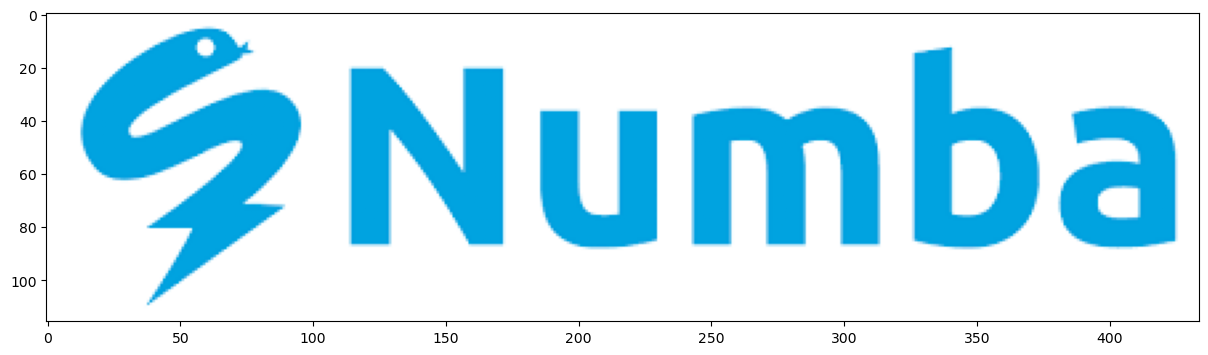

In [3]:
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/main/gpu-python-tutorial/images/numba.png
im = plt.imread('numba.png')
plt.imshow(im)

**2. 将图像移动到 GPU 并创建一个相同大小的输出数组。**

In [4]:
gpu_im = cuda.to_device(im)
gpu_output = cuda.to_device(np.zeros_like(gpu_im))

**3. 设置二维线程大小和块大小。** _提示：我们的 `threadsperblock` 相乘仍应等于 `128`。_

In [5]:
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(gpu_im.shape[0]/threadsperblock[0])
blockspergrid_y = math.ceil(gpu_im.shape[1]/threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

**4. 编写内核函数。**

In [7]:
@cuda.jit
def black_white(im, output):
    # 使用二维网格，我们可以获取二维的索引位置
    x, y = cuda.grid(2)

    # 因为我们的网格比图像稍大，所以应该忽略图像外的任何内容
    if x < im.shape[0] and y < im.shape[1]:

        # 计算 RGB 通道的平均值
        average = (im[x, y, 0] + im[x, y, 1] + im[x, y, 2]) / 3

        # 将所有输出 RGB 通道设置为平均值
        output[x, y, 0] = average
        output[x, y, 1] = average
        output[x, y, 2] = average

        # 传递 alpha 通道
        output[x, y, 3] = im[x, y, 3]

**5. 运行内核函数。**

In [8]:
black_white[blockspergrid, threadsperblock](gpu_im, gpu_output)

**6. 将数据从 GPU 移回并绘制。**

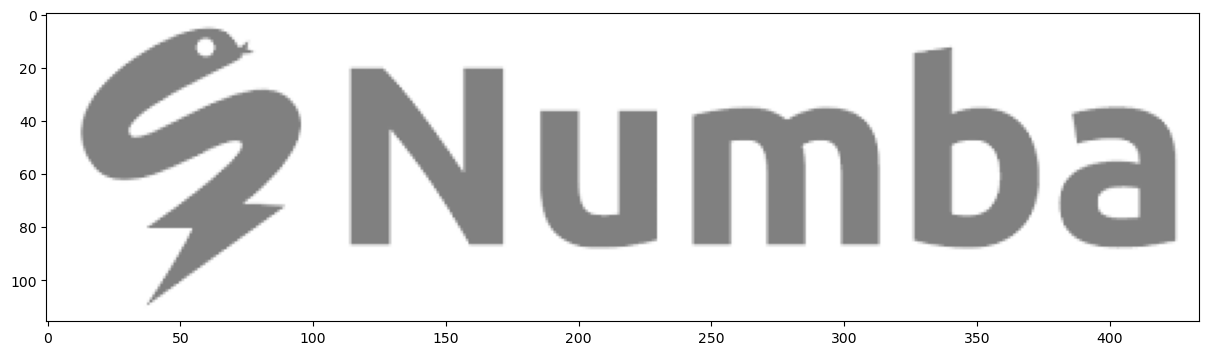

In [9]:
plt.imshow(gpu_output.copy_to_host())